In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk

from PIL import Image

from matplotlib.patches import Circle

from matplotlib.animation import FuncAnimation

# clipped_non_gate_img3d.shape

from scipy.ndimage import label, center_of_mass
from skimage.measure import regionprops
import math
from skimage.morphology import remove_small_objects


from scipy.ndimage import zoom
from scipy.optimize import minimize

import cv2


DATA_COLLECTION = "/mnt/labnas/DataCollection"

base_dir = os.path.join(DATA_COLLECTION, "Project", "RadiSmart", "cardiac", "healthy")
# dst_dir = os.path.join(DATA_COLLECTION, "Project", "RadiSmart", "cardiac", "healthy_nii")


demo_dir = os.path.join(base_dir, "000652515")

In [2]:
def read_sitk_img(path):
    sitk_img = sitk.ReadImage(path)
    img_arr = sitk.GetArrayFromImage(sitk_img)
    # SimpleITK: image[x,y,z]; numpy: image_numpy_array[z,y,x]
    print(f"img meta: \n shape:{img_arr.shape} \n spacing:{sitk_img.GetSpacing()[::-1]}")
    return img_arr


non_gate_img3d = read_sitk_img(os.path.join(demo_dir, "154"))
gate_img4d = read_sitk_img(os.path.join(demo_dir, "155"))
view_results3d = read_sitk_img(os.path.join(demo_dir, "161"))


img meta: 
 shape:(17, 64, 64) 
 spacing:(6.6437, 6.643699, 6.643699)
img meta: 
 shape:(136, 64, 64) 
 spacing:(6.6437, 6.643699, 6.643699)
img meta: 
 shape:(9, 20, 340) 
 spacing:(6.6437, 6.643699, 6.643699)


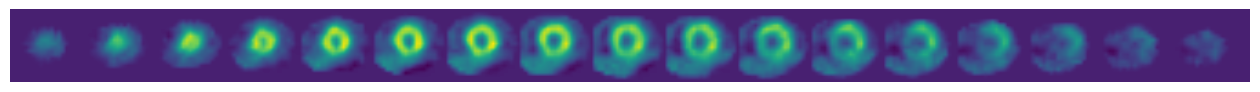

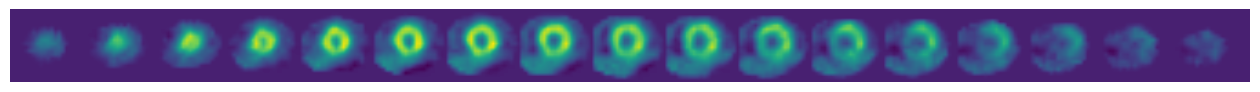

In [3]:

plt.figure(figsize=(16, 5))
plt.imshow(view_results3d[0], interpolation="bilinear")
plt.axis('off')
plt.show()


width = 20
# 计算中心位置
center = np.array(non_gate_img3d.shape)//2
start = center - width//2
end = center + width//2
# start = center - 8
# end = center + 12

clipped_non_gate_img3d = non_gate_img3d[:, start[1]:end[1], start[2]:end[2]].copy()
plt.figure(figsize=(16, 5))
plt.imshow(clipped_non_gate_img3d.transpose(1, 0, 2).reshape(width, -1), interpolation="bilinear")
plt.axis('off')
plt.show()


clipped_gate_img4d = gate_img4d[:, start[1]:end[1], start[2]:end[2]].copy()
unit = clipped_gate_img4d.shape[0] // 8

# plt.rcParams["animation.html"] = "jshtml"
# fig = plt.figure(figsize=(13, 1))
# plt.ioff()
# def animate(t):
#     plt.cla()
#     # plt.plot(x-t,x)
#     frame_i = clipped_gate_img4d[t*unit: (t+1)*unit]
#     plt.imshow(frame_i.transpose(1, 0, 2).reshape(width, -1), interpolation="bilinear")
#     plt.axis('off')  # Hide axes and ticks completely
#     plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove padding
#     # plt.xlim(0,10)

# # Create animation
# FuncAnimation(fig, animate, frames=8)
# plt.show()

(51, 60, 60)
限制条件:  min_volume:3682.9332354152602, min_distance:26.070577861323137
当前连通域:  volume:18104.0, distance:6.253342264905216


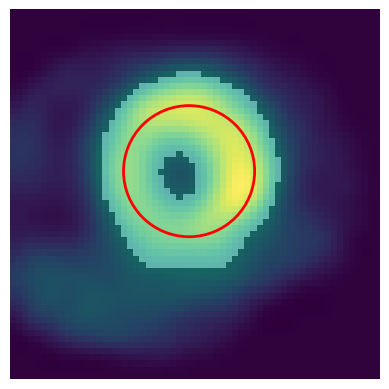

左心室中心: (25.761494252873565, 28.570402298850574), 半径: 10.642710525400847


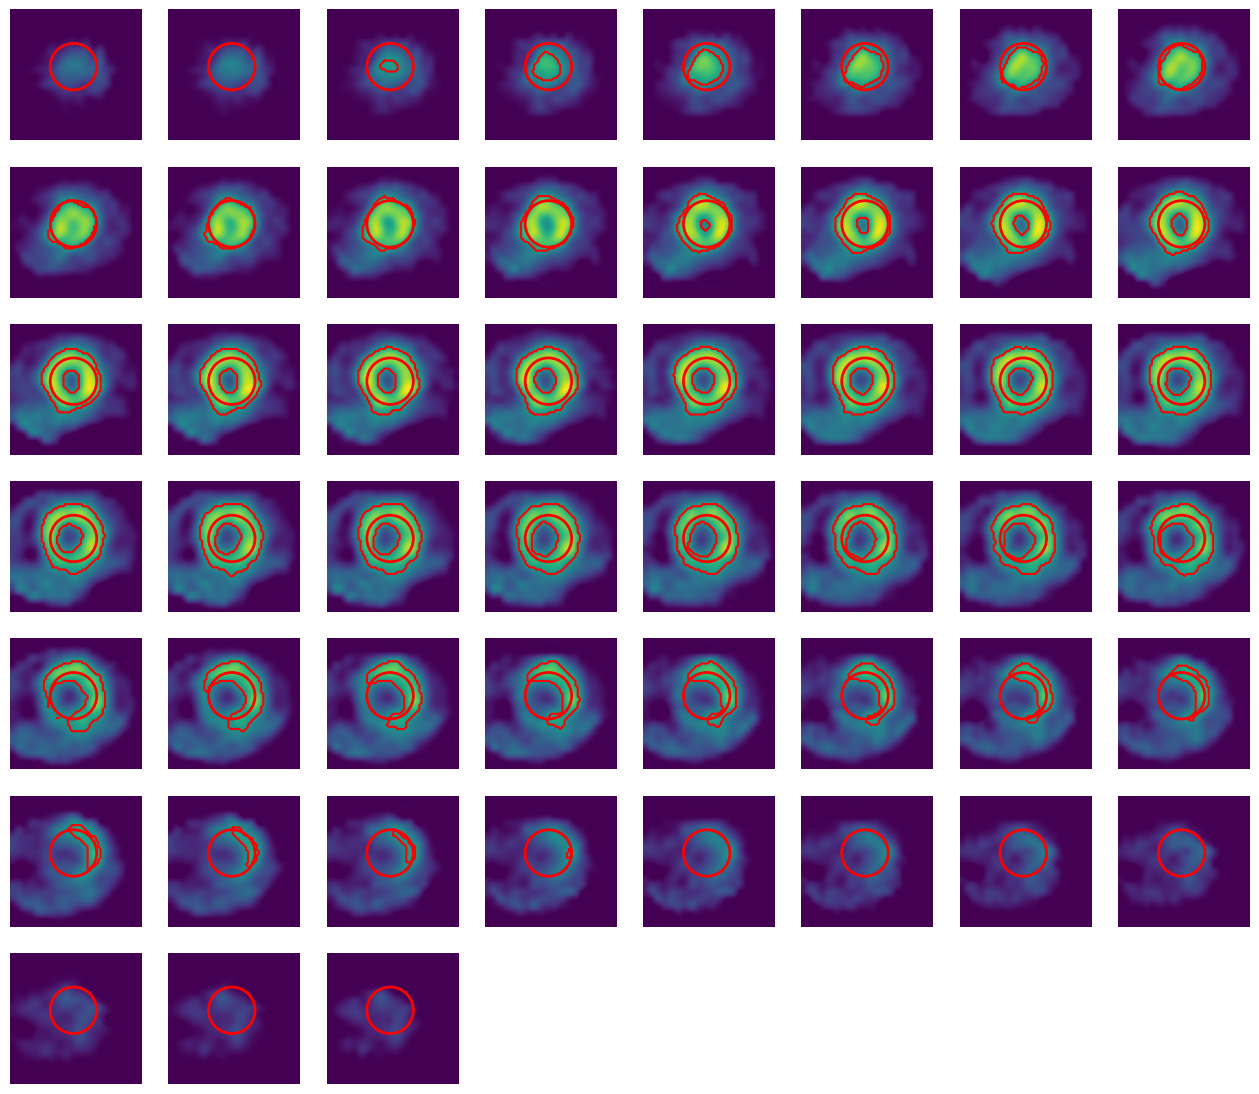

In [4]:
def find_lv_mask(img3d, pixel_size=(6.6437, 6.643699, 6.643699)):
    _img3d = img3d.copy()
    _pixel_size = np.array(pixel_size).copy()
    
    max_intensity = np.max(_img3d)
    threshold = 0.5 * max_intensity
    success = False
    # 40 ml = 40000 mm^3
    min_volume = 40000/math.prod(_pixel_size)
    
    lv_mask = np.zeros_like(img3d, dtype=np.uint8)
    while threshold <= max_intensity:
        binary_image = _img3d > threshold
        labeled_image, num_features = label(binary_image)
        
        center = np.array(img3d.shape) / 2
        # 5 cm = 50 mm
        min_distance = 100/np.linalg.norm(_pixel_size)
        
        for region in regionprops(labeled_image):
            centroid = np.array(region.centroid)
            distance = np.linalg.norm(centroid - center)
            
            # print(f"限制条件:  min_volume:{min_volume}, min_distance:{min_distance}")
            # print(f"当前连通域:  volume:{region.area}, distance:{distance}")
            
            # 检查区域是否对称且体积大于最小阈值
            if distance < min_distance and region.area >= min_volume:
                lv_mask[labeled_image == region.label]=1
                
        if np.sum(lv_mask):
            success = True
            
            print(f"限制条件:  min_volume:{min_volume}, min_distance:{min_distance}")
            print(f"当前连通域:  volume:{region.area}, distance:{distance}")
            break
        # 提高阈值
        threshold += 0.05 * max_intensity
        
    return success, lv_mask


def fit_lv_circle(img3d, factor=0.8):
    z_len, y_len, x_len = img3d.shape
    slice_len = int(z_len*factor)
    s_start = (z_len - slice_len)//2
    s_end = z_len-s_start
    
    sliced_img3d = img3d[s_start:s_end].copy()
    summed_img2d = np.sum(sliced_img3d, axis=0)
    max_intensity = np.max(summed_img2d)
    binary_slice = summed_img2d > (0.5 * max_intensity)
    
    ys, xs = np.ogrid[:y_len, :x_len]
    # 计算质心作为圆心
    cy, cx = center_of_mass(binary_slice)
    # radius = 10
    distance2center = np.sqrt((ys - cy) ** 2 + (xs - cx) ** 2)
    cost_func = lambda params: np.sum(summed_img2d*binary_slice * (np.abs(distance2center - params[0])))
    
    # 初始猜测：图像中心作为圆心，半径初始值为图像尺寸的 1/3
    result = minimize(cost_func, x0 = [summed_img2d.shape[0] / 3], bounds=[(1, summed_img2d.shape[0]//2)])
    radius = result.x.item()  # 拟合得到的圆心和半径
    
    return (cy, cx), radius, (summed_img2d, binary_slice)

def naive_lv_segmentation(img3d, pixel_size=(6.6437, 6.643699, 6.643699)):
    # 步骤1：找到左心室候选簇
    success, init_lv_mask = find_lv_mask(img3d, pixel_size)
    
    if not success:
        raise ValueError("未能找到左心室候选簇。")
    
    # 步骤3：拟合圆形区域
    center, radius, (summed_img2d, binary_slice)  = fit_lv_circle(img3d, 0.8)
    cy, cx = center
    
    
    # print(radius)
    ax = plt.subplot(111)
    plt.imshow(summed_img2d)
    plt.imshow(binary_slice, cmap='gray', alpha=0.3)
    circle = Circle((cx, cy), radius, edgecolor='r', facecolor='none', linewidth=2)  # 'r' 是红色边缘，'none' 表示圆内透明
    ax.add_patch(circle)
    # plt.scatter()
    
    ax.set_axis_off()
    plt.show()
    
    print(f"左心室中心: {center}, 半径: {radius}")
    
    return init_lv_mask, {"center": {"cy": cy, "cx": cx}, "radius": radius}


zoomed_clipped_non_gate_img3d = zoom(clipped_non_gate_img3d, 3, cval=0)

print(zoomed_clipped_non_gate_img3d.shape)
init_lv_mask, info = naive_lv_segmentation(zoomed_clipped_non_gate_img3d, np.array((6.6437, 6.643699, 6.643699))/3)


plt.figure(figsize=(16, 16))

import cv2
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)

    # 查找轮廓
    contours, _ = cv2.findContours(init_lv_mask[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # cv2.drawContours(clipped_non_gate_img3d[i], contours, -1, (255), 2)  # 在空白画布上绘制轮廓
    
    # plt.imshow(mask[i])
    plt.imshow(zoomed_clipped_non_gate_img3d[i], vmin=0, vmax=np.max(zoomed_clipped_non_gate_img3d))
    
    # 画轮廓
    for contour in contours:
        contour = contour.squeeze()  # 去掉冗余维度
        if len(contour.shape) == 2:  # 避免空轮廓
            contour = np.vstack([contour, contour[0]])
            ax.plot(contour[:, 0], contour[:, 1], color='r', linewidth=1.5)
    
    center = info["center"]
    radius = info["radius"]
    cy, cx = center["cy"], center["cx"]
    circle = Circle((cx,cy), radius, edgecolor='r', facecolor='none', linewidth=2)  # 'r' 是红色边缘，'none' 表示圆内透明
    ax.add_patch(circle)
    
    ax.set_axis_off()
plt.show()


In [5]:
def gen_cylinder_mask(img3d, info):
    
    z_len, y_len, x_len = img3d.shape  # 使用 img3d 的形状
    # 使用 np.ogrid 生成三维坐标网格
    zs, ys, xs = np.ogrid[:z_len, :y_len, :x_len]
    center = info["center"]
    radius = info["radius"]
    
    radius = radius+3
    
    cy, cx = center["cy"], center["cx"]
    
    # 计算每个点与圆心在 XY 平面上的距离 (忽略 z 轴)
    distance_xy = np.sqrt((ys - cy) ** 2 + (xs - cx) ** 2)
    # 生成掩膜：如果距离小于半径则为1，否则为0
    cylinder_mask = (distance_xy <= radius).astype(np.uint8)
    
    # print(cylinder_mask.shape)
    
    # for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    #     ax = plt.subplot(8,8,i+1)
    #     ax.imshow(cylinder_mask[i])
    # plt.show()
    return cylinder_mask


def locate_apex_base(img3d, info):
    # z 方向: 0->zlen, apex->base
    cylinder_mask = gen_cylinder_mask(img3d, info)
    img3d = img3d * cylinder_mask
    
    max_volume = img3d.max()
    
    z_len = img3d.shape[0]
    base_z, apex_z = z_len//2, z_len//2
    
    # The apex is considered to be the first slice apical to the center slice 
    # that does not contain a pixel greater than 40% of the maximum
    zs,ys,xs = np.where(img3d>0.4*max_volume)
    
    # 防止为空
    meets_list = [val for val in range(0, z_len//2) if val not in np.unique(zs)] + [0]
    print(f"np.unique(zs): {np.unique(zs)}, meets_list: {meets_list}")
    apex_z = max(max(meets_list), 0)
    
    zs,ys,xs = np.where(img3d>0.65*max_volume)
    meets_list = [val for val in range(z_len//2, z_len) if val not in np.unique(zs)] + [z_len-1]
    base_z = min(min(meets_list), z_len-1)
    
    # print(np.unique(zs))
    return {"base": base_z, "apex": apex_z}

# init_lv_mask, info = naive_lv_segmentation(zoomed_clipped_non_gate_img3d, np.array((6.6437, 6.643699, 6.643699))/3)

loc_info = locate_apex_base(zoomed_clipped_non_gate_img3d, info)
info.update(loc_info)

print(info)

np.unique(zs): [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46], meets_list: [0, 0]
{'center': {'cy': 25.761494252873565, 'cx': 28.570402298850574}, 'radius': 10.642710525400847, 'base': 41, 'apex': 0}


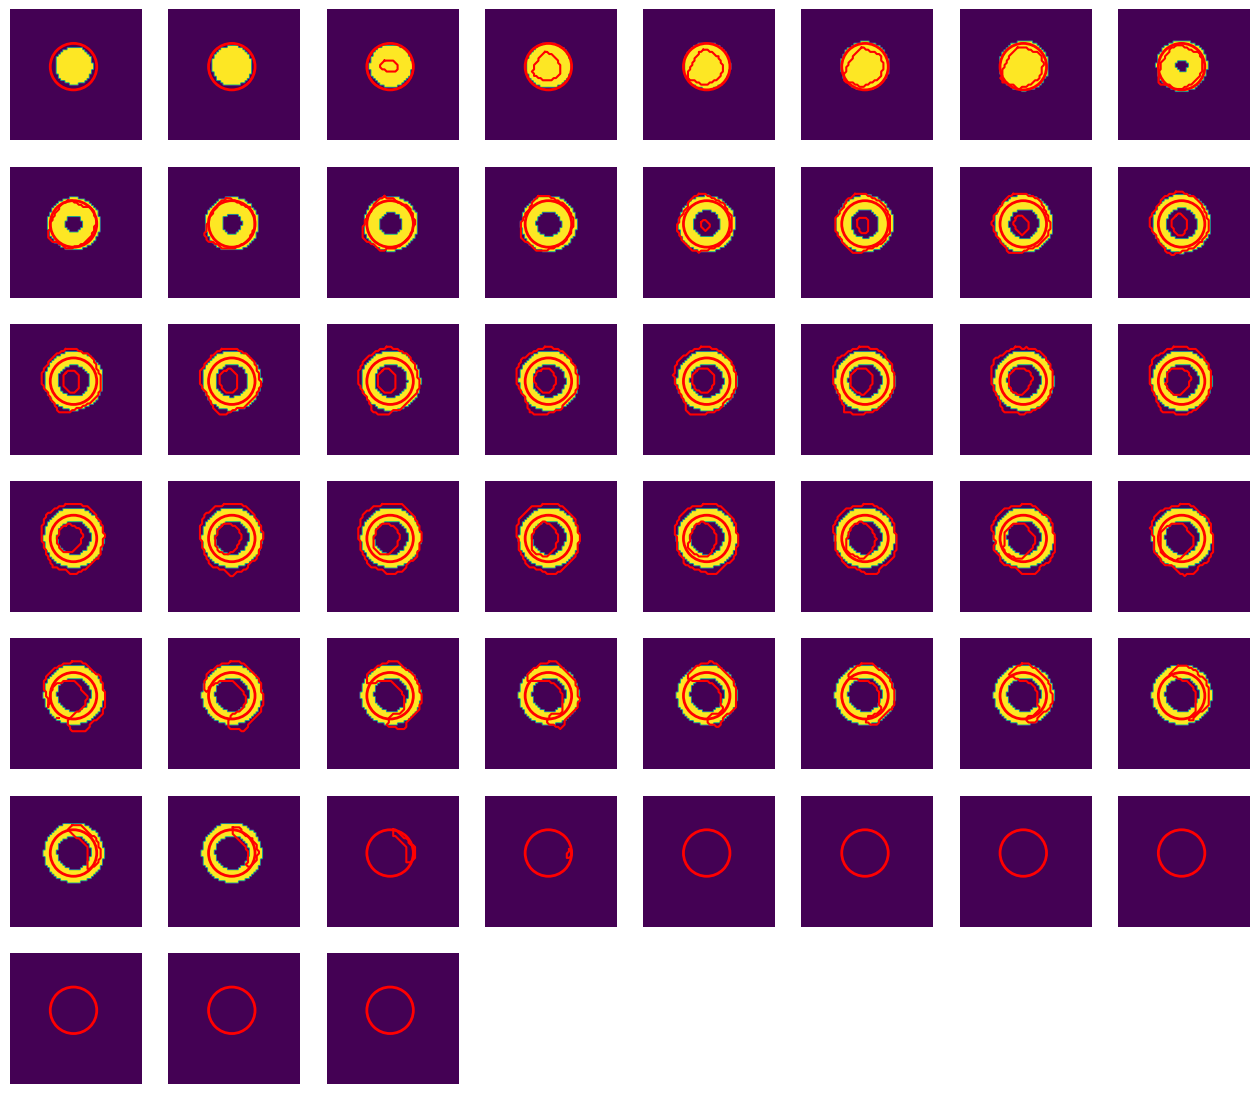

In [ ]:
lv_mask_3d = np.zeros_like(zoomed_clipped_non_gate_img3d)


def gen_hybird_mask3d(img3d, info, thickness=3):
    imgz, imgy, imgx = img3d.shape  # 使用 img3d 的形状
    # 使用 np.ogrid 生成三维坐标网格
    z, y, x = np.ogrid[:imgz, :imgy, :imgx]
    center = info["center"]
    radius = info["radius"]
    
    cy, cx = center["cy"], center["cx"]
    base_z = info["base"]
    apex_z = info["apex"]

    
    apex_len = 2*radius
    dividing_z = apex_z+apex_len
    # 计算每个点与圆心在 XY 平面上的距离 (忽略 z 轴)
    distance_xy = np.sqrt((y - cy) ** 2 + (x - cx) ** 2)
    # 生成掩膜：如果距离小于半径则为1，否则为0
    # 空心圆柱环: 大于心肌中线-3个像素, 小于新机中线-3个像素, 同时位置在 心机中间 到->base
    cylinder_mask = ((distance_xy <= radius+thickness) & (distance_xy >= radius-thickness) & (z<=base_z) & (z>=dividing_z)).astype(np.uint8)
    
    
    distance_semicircle = np.sqrt((y - cy) ** 2 + (x - cx) ** 2 + ((z-dividing_z)/2) ** 2)
    semicircle_mask = ((distance_semicircle <= radius+thickness) & (distance_semicircle >= radius-thickness) & (z<=dividing_z)).astype(np.uint8)
    # semicircle_mask = ((distance_semicircle <= radius+thickness) & (z<=apex_z+radius)).astype(np.uint8)
    
    hybird_mask = cylinder_mask | semicircle_mask
    
    return hybird_mask


hybird_mask3d = gen_hybird_mask3d(zoomed_clipped_non_gate_img3d, info)




plt.figure(figsize=(16, 16))
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    
    # 反转掩膜：找到0区域的轮廓
    # inverted_mask = np.uint8(mask[i] == 0)  # 创建一个反转的掩膜，0变成1，1变成0

    # 查找轮廓
    contours, _ = cv2.findContours(init_lv_mask[i], cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    # cv2.drawContours(clipped_non_gate_img3d[i], contours, -1, (255), 2)  # 在空白画布上绘制轮廓
    
    # plt.imshow(mask[i])
    plt.imshow(hybird_mask3d[i])
    
    # 画轮廓
    for contour in contours:
        contour = contour.squeeze()  # 去掉冗余维度
        if len(contour.shape) == 2:  # 避免空轮廓
            contour = np.vstack([contour, contour[0]])
            ax.plot(contour[:, 0], contour[:, 1], color='r', linewidth=1.5)
    
    center = info["center"]
    radius = info["radius"]
    
    cy, cx = center["cy"], center["cx"]
    circle = Circle((cx,cy), radius, edgecolor='r', facecolor='none', linewidth=2)  # 'r' 是红色边缘，'none' 表示圆内透明
    ax.add_patch(circle)
    
    ax.set_axis_off()


plt.show()

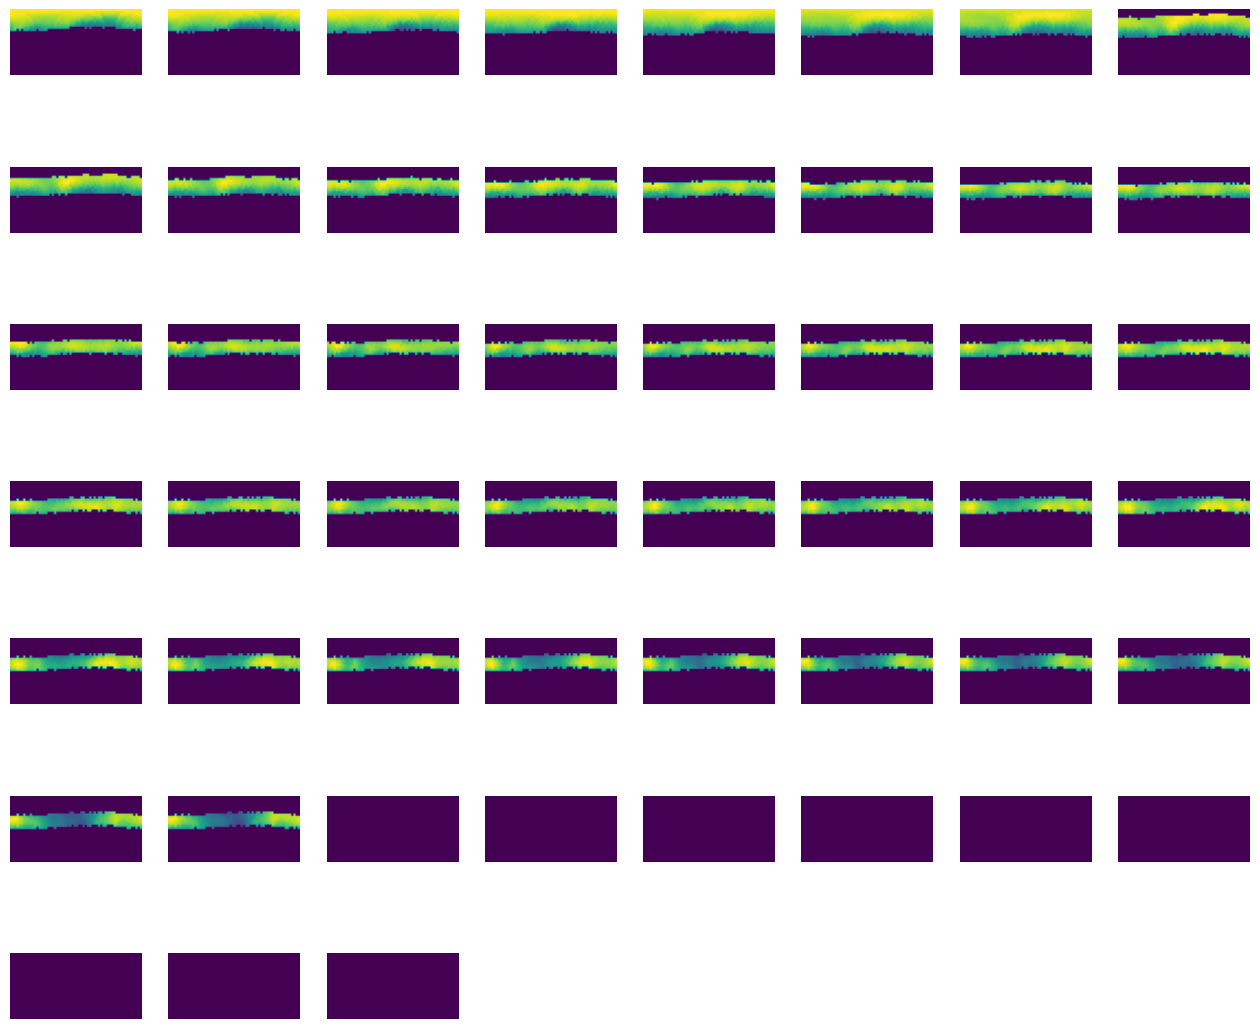

In [7]:
import numpy as np

def polor_unfold_vector_optimized(img3d, center):
    """
    将图像从笛卡尔坐标系转换为极坐标系（优化版）。
    """
    z_len, y_len, x_len = img3d.shape
    
    # zs * rs * thetas
    out_z, out_y, out_x = (z_len, x_len//2, y_len)
    
    cy, cx = center["cy"], center["cx"]
    
    # 创建空的极坐标图像
    polar_img3d = np.zeros((out_z, out_y, out_x), dtype=np.float32)

    # 计算所有的半径和角度值
    r_vals = np.linspace(0, out_y, out_y, endpoint=False)  # 半径值
    theta_vals = np.linspace(0, 2 * np.pi, out_x, endpoint=False)  # 角度值

    # 创建网格，计算每个点的 x 和 y 坐标
    r_grid, theta_grid = np.meshgrid(r_vals, theta_vals, indexing="ij")
    
    # 计算极坐标到笛卡尔坐标的转换
    x_vals = cx + r_grid * np.cos(theta_grid)  # x 坐标
    y_vals = cy + r_grid * np.sin(theta_grid)  # y 坐标
    
    # 限制坐标范围
    x_vals = np.clip(x_vals, 0, x_len - 1).astype(int)
    y_vals = np.clip(y_vals, 0, y_len - 1).astype(int)
    
    # 使用矩阵索引将笛卡尔坐标映射到极坐标图像
    polar_img3d = img3d[:, y_vals, x_vals]

    # return polar_img.transpose() # 如果需要与 OpenCV mat 轴一致的话
    return polar_img3d


polor_img3d = polor_unfold_vector_optimized(zoomed_clipped_non_gate_img3d*hybird_mask3d, info["center"])
plt.figure(figsize=(16, 16))

import cv2
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    # plt.imshow(mask[i])
    plt.imshow(polor_img3d[i])
    ax.set_axis_off()
plt.show()

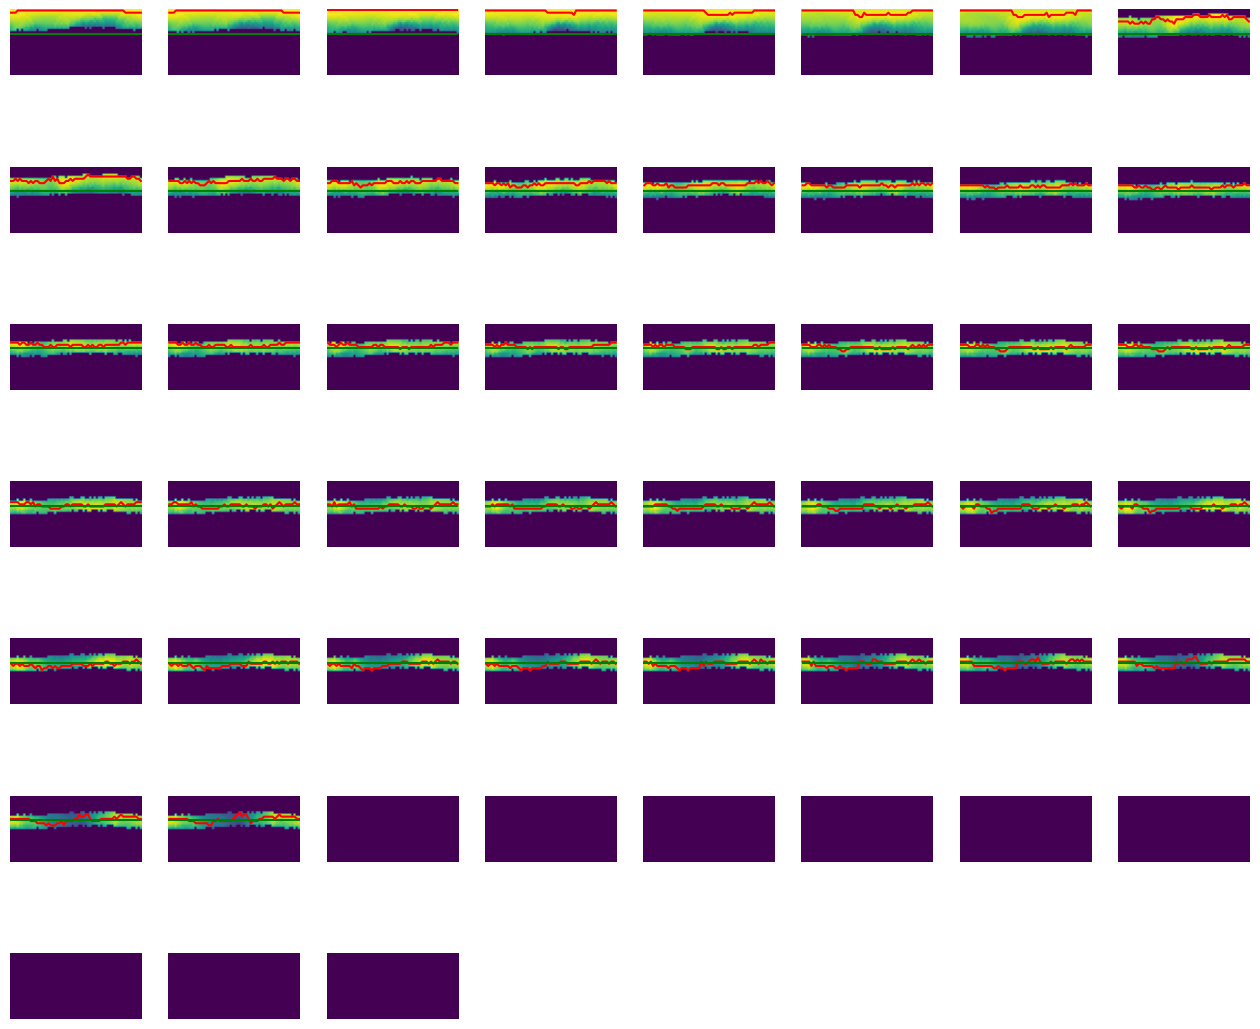

In [23]:
def find_max_val(polor_img3d):
    z_len, y_len, x_len = polor_img3d.shape
    lines = []
    
    for i in range(z_len):
        # slice_line = []
        if np.sum(polor_img3d[i]) == 0:
            lines.append({})
            continue
        
        # print(polor_img3d[i].shape)
        ys = np.argmax(polor_img3d[i], axis=0)
        # xs = list(range((x_len)))
        xs = np.linspace(0, 2 * np.pi, x_len, endpoint=False)  # 角度值
        vals = np.max(polor_img3d[i], axis=0)
        lines.append({"ys": ys, "xs": xs, "vals": vals})
    
    return lines
        # break

myocardium_info = find_max_val(polor_img3d)



plt.figure(figsize=(16, 16))

import cv2
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    # plt.imshow(mask[i])
    plt.imshow(polor_img3d[i])
    
    slice_line = myocardium_info[i]
    
    radius = info["radius"]
    if len(slice_line):
        # print(slice_line)
        plt.plot(range(len(slice_line["xs"])), slice_line["ys"], 'r')
        plt.plot(range(len(slice_line["xs"])), [radius]*len(slice_line["xs"]), 'g')
        # print()
    ax.set_axis_off()
plt.show()


In [24]:
def get_new_info(img3d, myocardium_info, old_info):
    
    center = old_info["center"]
    radius = old_info["radius"]
    
    cy, cx = center["cy"], center["cx"]
    base_z = old_info["base"]
    apex_z = old_info["apex"]
    
    
    dividing_point = int(apex_z + 2*radius)
    base3of4_start = dividing_point
    base_len = base_z-base3of4_start
    
    base3of4_end = int(base_z - int(base_len*0.75))
    
    # myocardium_radius = np.zeros((base3of4_end-base3of4_start, ))
    myocardium_radius = []
    myocardium_theta = []
    # print(base3of4_start, base3of4_end)
    for i in range(base3of4_start, base3of4_end, 1):
        slice_line = myocardium_info[i]
        # print(slice_line)
        myocardium_radius.append(slice_line["ys"])
        myocardium_theta.append(slice_line["xs"])
        
    
    myocardium_radius = np.array(myocardium_radius)
    myocardium_theta = np.array(myocardium_theta)
    
    new_radius = np.median(myocardium_radius)
    
    print(new_radius)
    
    # 去个尾 删除冗余数据
    myocardium_radius.sort(axis=0)
    
    xs = myocardium_radius[1:-1] * np.cos(myocardium_theta[1:-1]) + cx
    ys = myocardium_radius[1:-1] * np.sin(myocardium_theta[1:-1]) + cy
    
    new_cy, new_cx = np.mean(ys), np.mean(xs)
    
    new_info = {
        "center": {
            "cy": new_cy,
            "cx": new_cx,
        },
        "radius": new_radius,
        "dividing_point": dividing_point
    }
    
    
    
    # loc_info = locate_apex_base_round2(img3d, old_info, new_info, myocardium_info)
    
    return new_info
    
    
    
new_info = get_new_info(zoomed_clipped_non_gate_img3d, myocardium_info, info)


print(f"old_info: {info}")
print(f"new_info: {new_info}")

10.0
old_info: {'center': {'cy': 25.761494252873565, 'cx': 28.570402298850574}, 'radius': 10.642710525400847, 'base': 41, 'apex': 0}
new_info: {'center': {'cy': 25.80284857978233, 'cx': 28.2481623715037}, 'radius': 10.0, 'dividing_point': 21}


804 575.285784554845 127
804 577.6623015873016 132
222222 39.266666666666666
39


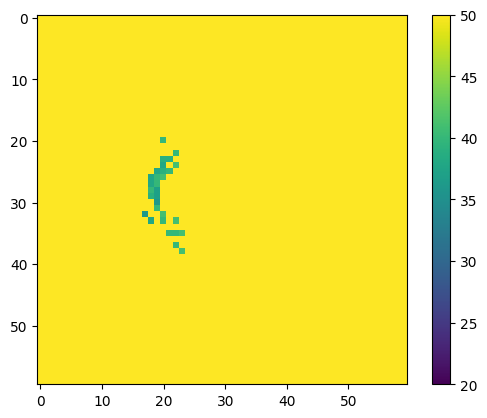

In [ ]:
def locate_apex_base_round2(img3d, old_info, new_info, myocardium_info):    
    # 求 新的 apex_z, base_z
    # 这里改掉了, 第一个出现 r = 0 而且, len(r=0) > 0.5 的 slice
    # print(dividing_point)
    dividing_z = new_info["dividing_point"]
    new_apex_z = 0
    for i in range(dividing_z, -1, -1):
        # print(i)
        slice_line = myocardium_info[i]
        ys = slice_line["ys"]
        
        if np.count_nonzero(ys == 0) >= 0.5*len(ys):
            new_apex_z = max(i-1, 0)
            break
    
    # 这里是old
    cardiac_center = (old_info["base"] + old_info["apex"])/2
    
    # the sampled myocardia intensity fell to 30% of the maximum sampled counts.
    cylinder_mask = gen_cylinder_mask(img3d, new_info)
    max_volume = np.max(img3d * cylinder_mask)
    
    # zs, ys, xs = np.where(img3d<=0.3*max_volume)
    # z_map = np.ones_like(img3d[0], dtype=np.uint8)*255
    # for z,y,x in zip(zs,ys,xs):
    #     if z < cardiac_center:
    #         continue
    #     z_map[y, x] = min(z_map[y,x], z)
    # z_map = z_map*cylinder_mask[0]
    
    # new_base_z1 = np.mean(z_map[z_map>0])
    # print(1111, "new_base_z1", new_base_z1)
    
    
    center = old_info["center"]
    # radius = old_info["radius"]
    cy, cx = center["cy"], center["cx"]
    
    polor_radius = []
    polor_thetas = []
    polor_zs = []
    vals = []
    for zi, slice_myocardium_info in enumerate(myocardium_info):
        if len(slice_myocardium_info) == 0:
            continue
        # print(zi, slice_myocardium_info)
        polor_zs.extend(np.ones_like(slice_myocardium_info["ys"])*zi)
        polor_radius.extend(slice_myocardium_info["ys"])
        polor_thetas.extend(slice_myocardium_info["xs"])
        vals.extend(slice_myocardium_info["vals"])
        
        
    
    polor_zs = np.array(polor_zs)
    polor_radius = np.array(polor_radius)
    polor_thetas = np.array(polor_thetas)
    
    decare_ys = polor_radius * np.sin(polor_thetas) + cy
    decare_xs = polor_radius * np.cos(polor_thetas) + cx
    decare_ys = np.round(decare_ys).astype(np.uint8)
    decare_xs = np.round(decare_xs).astype(np.uint8)
    decare_zs = np.array(polor_zs, np.uint8)
    
    myocardium_mask3d = np.zeros_like(img3d)
    myocardium_mask3d[decare_zs, decare_ys, decare_xs] = 1
    
    
    myocardium_img3d = img3d*myocardium_mask3d
    filt = myocardium_mask3d>0
    print(np.max(myocardium_img3d[filt]), np.mean(myocardium_img3d[filt]), np.min(myocardium_img3d[filt]))
    print(np.max(vals), np.mean(vals), np.min(vals))
    
    
    
    # print(myocardium_mask3d.shape, np.max(myocardium_mask3d))
    # plt.figure(figsize=(40, 40))
    # for i in range(myocardium_mask3d.shape[0]):
    #     ax = plt.subplot(8,8,i+1)
        
    #     if i < cardiac_center:
    #         continue
        
    #     tmp = np.zeros_like(myocardium_img3d[i])
    #     filt1 = (myocardium_img3d[i]<=0.3*max_volume) & (myocardium_mask3d[i]>0)
    #     filt2 = (myocardium_img3d[i]>0.3*max_volume) & (myocardium_mask3d[i]>0)
        
    #     tmp[filt1]=1
    #     tmp[filt2]=2
        
    #     ax.set_axis_off()
    #     plt.imshow(tmp, vmax=2)
        
        
    zs, ys, xs = np.where(((img3d*myocardium_mask3d)<=(0.3*max_volume)) & (myocardium_mask3d>0))
    z_map = np.ones_like(img3d[0], dtype=np.uint8)*255
    for z,y,x in zip(zs,ys,xs):
        if z < cardiac_center:
            continue
        z_map[y, x] = min(z_map[y,x], z)
    # z_map = z_map*cylinder_mask[0]
    
    
    plt.imshow(z_map, vmax=50, vmin=20)
    plt.colorbar()
    
    new_base_z1 = np.mean(z_map[z_map<255])
    print(222222, new_base_z1)
    
    
    # the first slice basal to the center slice in the short-axis volume that did not containa pixel greater than 65%
    zs, ys, xs = np.where(myocardium_img3d>=0.65*max_volume)
    meets_list = [val for val in np.unique(zs) if val > cardiac_center] + [int(cardiac_center)+1]
    # print(333333, np.unique(zs), meets_list)
    new_base_z2 = np.max(meets_list)
    print(new_base_z2)
    
    
    # If the two baseestimates differed by lessthan 2.5 pixels, the former estimatewasused;
    # otherwise,a basal defect was assumed, and the latter estimate was assumed to be the more accurate one
    if abs(new_base_z1-new_base_z2) <= 3:
        new_base_z = new_base_z1
    else:
        new_base_z = new_base_z2
    
    return {"base": new_base_z, "apex": new_apex_z}

new_loc_info = locate_apex_base_round2(zoomed_clipped_non_gate_img3d, info, new_info, myocardium_info)

new_info.update(new_loc_info)

In [58]:
print(info)
print(new_info)

{'center': {'cy': 25.761494252873565, 'cx': 28.570402298850574}, 'radius': 10.642710525400847, 'base': 41, 'apex': 0}
{'center': {'cy': 25.80284857978233, 'cx': 28.2481623715037}, 'radius': 10.0, 'dividing_point': 21, 'base': 39.266666666666666, 'apex': 5}


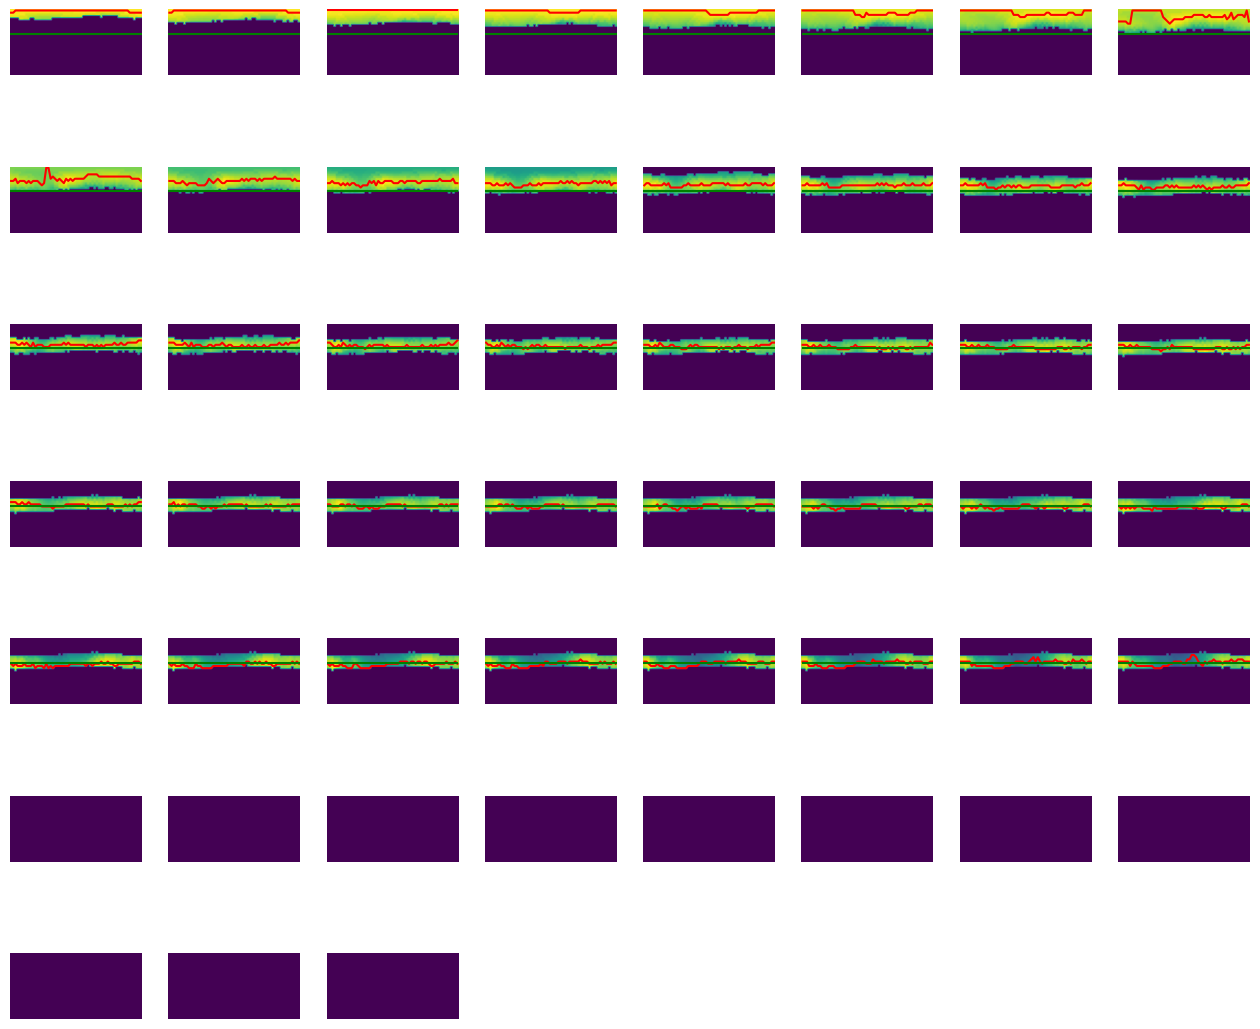

In [64]:
hybird_mask3d = gen_hybird_mask3d(zoomed_clipped_non_gate_img3d, new_info)
polor_img3d = polor_unfold_vector_optimized(zoomed_clipped_non_gate_img3d*hybird_mask3d, new_info["center"])
myocardium_info = find_max_val(polor_img3d)

plt.figure(figsize=(16, 16))

import cv2
for i in range(min(zoomed_clipped_non_gate_img3d.shape[0], 64)):
    ax = plt.subplot(8,8,i+1)
    # plt.imshow(mask[i])
    plt.imshow(polor_img3d[i])
    
    slice_line = myocardium_info[i]
    
    radius = info["radius"]
    if len(slice_line):
        # print(slice_line)
        plt.plot(range(len(slice_line["xs"])), slice_line["ys"], 'r')
        plt.plot(range(len(slice_line["xs"])), [radius]*len(slice_line["xs"]), 'g')
        # print()
    ax.set_axis_off()
plt.show()
